In [3]:
# 無駄話が多いようですが必要なことしか記載しておりません！
import numpy as np
import math
import CCR
import matplotlib.pyplot as plt

# パラメータ直接入力
GENDER = 'M'
AGE = 38
WEIGHT = 60
SCR = 2.0


# 投与量パターン・点滴時間　※多ければ多いほど処理に時間がかかります
DOSETYPE = [0, 500,  1000, 1250, 1500, 2000]  # 1時間あたりの投与量のリスト
TIMEINF = [1.0, 2.0]  # 点滴注射にかける時間のリスト

# ピークの目標濃度入力
Peak_max = 40
Peak_min = 25

# トラフの目標濃度入力
Trough_max = 20
Trough_min = 15

#ここで腎機能計算－－－－－－－－－－CCRをImportした上で

CCR= CCR.CCR(GENDER, AGE, SCR, WEIGHT)
print('CCR', format(CCR))

#ここで血中濃度計算－－－－－－－－－－

# 血中濃度計算　パラーメーター各種
k12 = 1.1199  # /hr
k21 = 0.4801  # /hr
V1 = 17.520 # L
DrugCL = CCR * 0.797 * 60 / 1000 / WEIGHT # 0.797は薬CL=0.797*CCRの意味 さらにml/min/kg -> L/hr/kgへ単位変換のため
VD = V1 / WEIGHT
k10 = DrugCL / VD # keと同じこと 排泄クリアランスの定数？
alpha = ((k12 + k21 + k10) + math.sqrt((k12 + k21 + k10) ** 2 - (4 * k21 * k10))) / 2
beta =  ((k12 + k21 + k10) - math.sqrt((k12 + k21 + k10) ** 2 - (4 * k21 * k10))) / 2

# 血中濃度Cp
#便宜上、CpAとCpBに分けております。
# k0 = 1時間あたりの投与量(mg/hour)　の意味です
# T: (そのトラフの元となるピーク生成の)投与の最初からの経過時間

def CpA(k0, T):
    return (k0 * (k21 - alpha))/(V1 * alpha * (beta - alpha)) * (1 - math.exp(- alpha * T))
def CpB(k0, T):
    return (k0 * (k21 - beta))/(V1 * beta * (alpha - beta )) * (1 - math.exp(- beta * T))

# これが肝心の血中濃度の関数
def Cp(k0, T, Tinf):
    if T <= Tinf: # ピークまでの数式 ピーク値の部分
        return CpA(k0, T) + CpB(k0, T)
    else: #ピーク以後の数式 トラフ値の部分
        return CpA(k0, Tinf) * math.exp(-alpha * (T-Tinf)) + CpB(k0, Tinf) * math.exp(-beta * (T-Tinf))

# これが肝心の血中濃度の関数の微分式
def CpDrv(k0, T, Tinf):
    if T <= Tinf: # ピークまでの数式 ピーク値の部分
        return alpha * (k0 * (k21 - alpha))/(V1 * alpha * (beta - alpha)) * math.exp(- alpha * T) + \
    beta * (k0 * (k21 - beta))/(V1 * beta * (alpha - beta )) * math.exp(- beta * T)
    
    else: #ピーク以後の数式 トラフ値の部分
        return (-alpha) * CpA(k0, Tinf) * math.exp(-alpha * (T-Tinf)) + (-beta) * CpB(k0, Tinf) * math.exp(-beta * (T-Tinf))

#血中濃度式はここまで－－－－－－－－－－

CCR 42.5


In [4]:
# 初回投与でピークMAXを超えない1時間あたりの投与時間と投与量の組み合わせ候補の生成
CANDPLAN = []
i = 0
for i in range(len(DOSETYPE)):
    for j in range(len(TIMEINF)):
        if Cp(DOSETYPE[i], TIMEINF[j], TIMEINF[j]) <= Peak_max: # 初回投与のピーク濃度がPeak_max以下ということ
            CANDPLAN.append([DOSETYPE[i], TIMEINF[j]])
    else:
        pass
print(CANDPLAN)

[[0, 1.0], [0, 2.0], [500, 1.0], [500, 2.0], [1000, 1.0]]


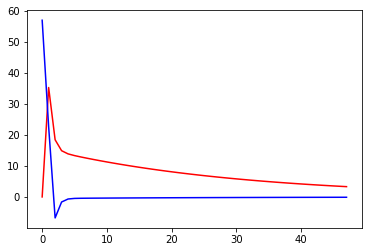

Cp [0.0, 35.343414371322346, 18.457690746346746, 14.932744980957336, 13.903266191104848, 13.349714805536237, 12.896397698587423, 12.47311499509613, 12.06644993334134, 11.673549995272259, 11.293537538142361, 10.92591322879727, 10.570258981379544, 10.226182397180525, 9.89330609507265, 9.571265395296878, 9.259707566430796, 8.958291373347855, 8.666686691270035, 8.384574141931456, 8.111644743359651, 7.847599571386724, 7.592149432239977, 7.345014545801621, 7.105924239180881, 6.874616650261182, 6.650838440897325, 6.434344519448517, 6.224897772343334, 6.022268804382606, 5.826235687495811, 5.636583717675781, 5.453105179825522, 5.275599120259602, 5.103871126610911, 4.93773311490178, 4.777003123546209, 4.62150511405762, 4.471068778243836, 4.3255293516781315, 4.18472743324206, 4.048508810542401, 3.9167242910110383, 3.7892295385027546, 3.6658849152120045, 3.5465553287355065, 3.4311100841131568, 3.319422740685223]
Cp微分 [57.07762557077625, 22.69443495353777, -6.782985624285551, -1.6411586082182934, -

In [5]:
# グラフ化のぱーと
# 血中濃度リスト作成
# CANDPLANごとに1時間毎の血中濃度をリストで作成
k = 48 #　グラフに表示する時間の設定
l = 4 # 表示するCANDPLANの種類
CANDPLANConc = [None]* len(CANDPLAN) #Cp式の表示
for i in range(len(CANDPLAN)):
    c = []
    for j in range(0, k, 1):
        c.append(Cp(CANDPLAN[i][0], j, CANDPLAN[i][1]))
    CANDPLANConc[i] = c
    
CANDPLANConcDrv = [None]* len(CANDPLAN) #CpDrv式の表示
for i in range(len(CANDPLAN)):
    c = []
    for j in range(0, k, ):
        c.append(CpDrv(CANDPLAN[i][0], j, CANDPLAN[i][1]))
    CANDPLANConcDrv[i] = c

#一応グラフ化
x = np.arange(0, k)
y1 = CANDPLANConc[l]
y2 = CANDPLANConcDrv[l]
plt.plot(x, y1, color='red') #Cp式は赤
plt.plot(x, y2, color='blue') #CpDrv式は青
plt.show()
print('Cp', CANDPLANConc[l])
print('Cp微分', CANDPLANConcDrv[l])


In [1]:
# トラフ値の計算
# BfrTrgh: 1つ前のトラフ値
def Trough(BfrTrghA, BfrTrghB, k0, T, Tinf):
    return (BfrTrghA + CpA(k0, Tinf)) * math.exp(- alpha * (T - Tinf)) + (BfrTrghB + CpB(k0, Tinf)) * math.exp(- beta * (T - Tinf))
